<a href="https://colab.research.google.com/github/gshaffer22/GIS3_Adv_Python/blob/main/CCVI_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Permissions
Run these cells for the initial imports. The arcgis package is used in this analysis. Once installed, the session may restart, so it is important to do this early on.

In [1]:

# analysis and mapping
import pandas as pd
import geopandas as gpd
import folium

import json

# file management stuff
import datetime
import glob
import urllib
import zipfile
from zipfile import ZipFile

# earth engine
import ee
import geemap.foliumap as geemap

import math




In [2]:
#Install arcgis if not already installed
!pip install arcgis

Traceback (most recent call last):
  File "/usr/lib/python3.12/pathlib.py", line 441, in __str__
    return self._str
           ^^^^^^^^^
AttributeError: 'PosixPath' object has no attribute '_str'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/pathlib.py", line 555, in drive
    return self._drv
           ^^^^^^^^^
AttributeError: 'PosixPath' object has no attribute '_drv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.

In [2]:
# then import GIS to be able to read and access ArcGIS online pages and layers
from arcgis.gis import GIS

gis = GIS()   # anonymous


# Authenticate your session
Run these chunks to authenticate your session and make sure you change the ee.Initialize(project= "YOUR PROJECT NAME) to your own earth engine project name.

In [3]:
ee.Authenticate()

True

In [4]:
# start the ee session
# Initialize the library.
ee.Initialize(project='useful-builder-474619-f1') # replace with your own earth engine project name


# Input Data & Initial Selection
Input the desired URL and county for which you wish to complete this analysis for. The URL should be:
*   data in the United States
*   a feature layer with polygons
*   open access from ArcGIS online

Example datasets include:

*   USA Wilderness https://www.arcgis.com/home/item.html?id=52c7896cdfab4660a595e6f6a7ef0e4d
*   US Census Urban Areas https://www.arcgis.com/home/item.html?id=10551da8fcd24062b1857473252b3df8

Example counties:


*   Multnomah County
*   Cowlitz County
*   Mariposa County









In [6]:
#INPUTS:
# Input the url to the arcgis data you wish to use, ensure the data is a feature layer with polygons AND it is in the United States
input_url = "https://www.arcgis.com/home/item.html?id=52c7896cdfab4660a595e6f6a7ef0e4d"

# this analysis focuses on data in the United States by county so please select a county name with the first letter of each word capitalized and spelled correctly

# Input the full name (first letter of each word capitalized) of the county you wish to query
countyname = "Mariposa County"

In [7]:
# correctly formatting your desired input data:
# for this analysis, your data should be from ArcGIS Online and a feature layer with polygon data
# examples include:

# Split on 'id=' and take the last part
# if statement to make sure the link is correct
if "id" in input_url:
    item_id = input_url.split("id=")[-1]
    print(item_id)
else:
    print("The link you chose is not compatible for this analysis. See the example links and make sure they align")


52c7896cdfab4660a595e6f6a7ef0e4d


In [10]:
# This is where the input layer is retrieved for the analysis
# the try-except helps with error checking, in case the link you submitted was not valid
try:
  item = gis.content.get(item_id) # load your data, using the numbers/letters after the id= in the url at the top of the webpage

  print(item)
except:
  print("The arcgis online link you submitted is not compatible with this analysis. Please make sure the url contains an ID and that the data is in the US, a feature layer, is polygon data, and is open access")


<Item title:"Wilderness Areas in the United States" type:Feature Layer Collection owner:wildernesswebmaster99>


In [11]:
# getting the layer from the input data from arcgis online
try:
  data_layer = item.layers[0]  # this should import if there is only one data layer
  #if there are multiple you may need to adjust the number (i.e 1) to get the correct layer

  print(data_layer)
except:
  print("The url you provided does not have a valid layer that can be used for this analysis.")



<FeatureLayer url:"https://services1.arcgis.com/ERdCHt0sNM6dENSD/arcgis/rest/services/Wilderness_Areas_in_the_United_States/FeatureServer/1">


In [12]:
#Check spatial reference
print(data_layer.properties.spatialReference)



{
  "wkid": 102100,
  "latestWkid": 3857
}


# Creating dataframes for input data
This section creates a spatial dataframe and a geodataframe from the data with the correct coordinate reference system.

In [13]:
# creating a spatial dataframe from your input data
df = data_layer.query().sdf

In [14]:
# converting the sdf to a gdf for your input data
gdf = gpd.GeoDataFrame(df, geometry='SHAPE')  # 'SHAPE' is the default geometry column in ArcGIS


In [15]:
# checking to make sure the data came in correctly
gdf.tail()

,OBJECTID,NAME,Land_Type,WID,Shape__Area,Shape__Length,GlobalID,CreationDate,Creator,EditDate,Editor,SHAPE
479,482,South Prince of Wales Wilderness,Non-Forest Service,567,694702.210938,9399.053144,33b43faa-fac0-4bec-b604-39509f5824ea,2023-04-24 19:42:22,wildernesswebmaster99,2023-04-24 19:42:22,wildernesswebmaster99,"MULTIPOLYGON (((-14729186.182 7337435.988, -14..."
480,483,Tebenkof Bay Wilderness,Non-Forest Service,595,387645.695312,7297.756486,18ac5cbd-2728-4c9f-96e9-a50cd6f5b04c,2023-04-24 19:42:22,wildernesswebmaster99,2023-04-24 19:42:22,wildernesswebmaster99,"MULTIPOLYGON (((-14927348.703 7649395.385, -14..."
481,484,Marble Mountain Wilderness,Non-Forest Service,340,486803.222656,4186.839614,11416c8a-6d2e-4b05-99f0-91c9c13f0946,2023-04-24 19:42:22,wildernesswebmaster99,2023-04-24 19:42:22,wildernesswebmaster99,"POLYGON ((-13734824.363 5074931.459, -13735187..."
482,485,Daniel J. Evans Wilderness,Non-Forest Service,428,371545.023438,5768.442277,35c72077-446d-4023-81ca-2f3610037326,2023-04-24 19:42:22,wildernesswebmaster99,2023-04-24 19:42:22,wildernesswebmaster99,"MULTIPOLYGON (((-13795213.808 6021010.865, -13..."
483,486,Devil's Staircase Wilderness,Non-Forest Service,786,291069.0,3991.020857,f79c340b-9bc8-493e-840d-5911e0be9c4d,2023-04-24 19:42:22,wildernesswebmaster99,2023-12-04 20:12:59,wildernesswebmaster99,"MULTIPOLYGON (((-13798513.516 5417565.764, -13..."


In [16]:
# checking that all the records came in
print(len(gdf))

484


In [17]:
# check for the coordinate system of your dataset
print(gdf.crs)


None


# Getting and processing the county boundary data
The state boundary data is also retrieved from an open source data layer on ArcGIS online. This is processed in this section.

This is the link to the county boundary data: https://www.arcgis.com/home/item.html?id=36a7fa832aea4b7e8266a8d983afa4ac

In [18]:
# this is where the county boundaries layer is retrieved
county = gis.content.get("36a7fa832aea4b7e8266a8d983afa4ac") # load your data, using the numbers/letters after the id= in the url at the top of the webpage
print(county)

<Item title:"United States County Boundaries" type:Feature Layer Collection owner:esri_dm>


In [19]:
# getting the layer from the county boundary data from arcgis online
county_layer = county.layers[2]
print(county_layer)

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Boundaries_2023/FeatureServer/2">


In [20]:
# creating a spatial dataframe from the county data
county_df = county_layer.query().sdf

In [21]:
# making a geodataframe from the county data
county_gdf = gpd.GeoDataFrame(county_df, geometry='SHAPE')  # 'SHAPE' is the default geometry column in ArcGIS


In [22]:
# printing the last 5 entries in the county dataframe to make sure they are converted to the gdf correctly
county_gdf.tail()

,OBJECTID,NAME,STATE_NAME,STATE_ABBR,STATE_FIPS,COUNTY_FIPS,FIPS,POPULATION,POP_SQMI,SQMI,POPULATION_2020,POP20_SQMI,Shape__Area,Shape__Length,SHAPE
3138,2803,Utah County,Utah,UT,49,049,49049,718194,334.94,2144.22,659399,307.5,0.586729,5.106125,"POLYGON ((-111.59389 40.57707, -111.59379 40.5..."
3139,2802,Uintah County,Utah,UT,49,047,49047,36706,8.15,4504.05,35620,7.9,1.232563,5.395294,"POLYGON ((-109.04896 40.66261, -109.04895 40.6..."
3140,3055,Burnett County,Wisconsin,WI,55,013,55013,16828,19.12,880.22,16526,18.8,0.264132,2.784881,"POLYGON ((-92.04964 46.15761, -92.04967 46.155..."
3141,3054,Buffalo County,Wisconsin,WI,55,011,55011,13234,18.65,709.59,13317,18.8,0.207539,2.265479,"POLYGON ((-92.00315 44.59684, -92.00093 44.596..."
3142,3053,Brown County,Wisconsin,WI,55,009,55009,274271,516.28,531.24,268740,505.9,0.155565,3.253008,"MULTIPOLYGON (((-87.9809 44.53818, -87.98061 4..."


# Joining your input data with the state boundaries
This section joins the two geodataframes (your input data AND the state boundary data).

In [23]:
print(gdf.crs)
print(county_gdf.crs)



None
None


In [24]:
# setting the spatial reference of the input data
sr = data_layer.properties.spatialReference
epsg = sr.get('latestWkid')
gdf.set_crs(epsg=epsg, inplace=True, allow_override=True)

print(gdf.crs)


EPSG:3857


In [25]:
# setting them to the same spatial referene based on the spatial reference of the input data
sr = data_layer.properties.spatialReference
epsg = sr.get('latestWkid')
county_gdf.set_crs(epsg=epsg, inplace=True, allow_override=True)

print(county_gdf.crs)


EPSG:3857


In [26]:
from shapely.geometry import shape

# Suppose your geometry column is called 'SHAPE'
county_gdf['geometry'] = county_gdf['SHAPE'].apply(shape)

# Set it as the active geometry
county_gdf = county_gdf.set_geometry('geometry')

# Suppose your geometry column is called 'SHAPE'
gdf['geometry'] = gdf['SHAPE'].apply(shape)

# Set it as the active geometry
gdf = gdf.set_geometry('geometry')


In [27]:
gdf['geometry'] = gdf['geometry'].buffer(0)
county_gdf['geometry'] = county_gdf['geometry'].buffer(0)


In [28]:
# Making a joined dataframe with the state and input data to be able to query the data by the initial county you chose a the beginning
try:
  joined_gdf = gpd.sjoin(
    gdf,
    county_gdf,
    how='inner',
    predicate='intersects',
    lsuffix='input',
    rsuffix='county'
)
except:
  "Your input data does not intersect with the county data, meaning your data is likely not in the United States. Please select another dataset."


In [29]:
list(joined_gdf.columns)


['OBJECTID_input',
 'NAME_input',
 'Land_Type',
 'WID',
 'Shape__Area_input',
 'Shape__Length_input',
 'GlobalID',
 'CreationDate',
 'Creator',
 'EditDate',
 'Editor',
 'SHAPE_input',
 'geometry',
 'index_county',
 'OBJECTID_county',
 'NAME_county',
 'STATE_NAME',
 'STATE_ABBR',
 'STATE_FIPS',
 'COUNTY_FIPS',
 'FIPS',
 'POPULATION',
 'POP_SQMI',
 'SQMI',
 'POPULATION_2020',
 'POP20_SQMI',
 'Shape__Area_county',
 'Shape__Length_county',
 'SHAPE_county']

In [30]:
joined_gdf.tail()

,OBJECTID_input,NAME_input,Land_Type,WID,Shape__Area_input,Shape__Length_input,GlobalID,CreationDate,Creator,EditDate,...,COUNTY_FIPS,FIPS,POPULATION,POP_SQMI,SQMI,POPULATION_2020,POP20_SQMI,Shape__Area_county,Shape__Length_county,SHAPE_county


# Selecting by county
This next part of the code selects the newly joined data for the county input at the beginning of this analysis.

In [32]:
# checking if the county name variable you input is valid
match = joined_gdf[joined_gdf['NAME_county'] == countyname]

if len(match) > 0:
    print(f"Your selection of {countyname} is a valid county name.")
else:
    print("Your county name is NOT valid.")

# IF your county name is not valid, input a new state name in the initial code block where it is defined (where your inputs are)

Your county name is NOT valid.


In [ ]:
# filtering the data and creating a new selection based on your filter
# returning how many, if any, features are located in your county
filtered_gdf = joined_gdf[joined_gdf['NAME_county'] == countyname]
# Check that any rows exist:

if filtered_gdf.empty:
    print("No features found for that county.")
else:
    print(f"Found {len(filtered_gdf)} features in {countyname}.")


Found 4 features in Mariposa County.


In [ ]:
# setting the correct WGS 84 coordinate reference system
filtered_gdf = filtered_gdf.to_crs(epsg=4326)


In [ ]:
# getting the centroid for the state you selected to have the correct map center
cent = filtered_gdf.centroid
centlong = cent.x.values[0]
centlat = cent.y.values[0]


/tmp/ipython-input-3434834619.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = filtered_gdf.centroid


In [ ]:
# making a feature collection layer that ee likes
ee_county = geemap.gdf_to_ee(filtered_gdf)


In [ ]:
# creating a map to check that the features appear correctly
# create the map variable
m = folium.Figure(width=800, height=600)
Map = geemap.Map(zoom=7)
Map.add_to(m)

# add your ee layer with the correct styling so it appears
Map.addLayer(
    ee_county,
    {'color': 'red', 'fillColor': 'FF000080', 'width': 2},
    f"Features in {countyname}"
)

# zoom to the county bounds
minx, miny, maxx, maxy = filtered_gdf.total_bounds
Map.fit_bounds([[miny, minx], [maxy, maxx]])

# add layer control to be able to control the map
Map.add_layer_control()

m



In [ ]:
# save this map as an html export
outhtml = f'{countyname}_{item.title}_Map.html'
m.save(outhtml)
print(f'Saved {outhtml}')


Saved Mariposa County_USA Parks_Map.html


# Getting the CCVI Data for analysis
The CCVI data is from arcgis online as well. It is linked here:
https://www.arcgis.com/home/item.html?id=0bd7d81a57224cbea9a33d7b1358bad4

CCVI is the [Climate Conflict Vulnerability Index](https://climate-conflict.org/www), commissioned by the German Federal Foreign Office to show the intersection of climate and conflict related impacts across ther world.

In [ ]:
# getting CCVI data from arcgis online in the same method
ccvi_gis = gis.content.get("0bd7d81a57224cbea9a33d7b1358bad4") # load your data, using the numbers/letters after the id= in the url at the top of the webpage
ccvi_gis


<Item title:"Climate Conflict Vulnerability Index (CCVI)" type:Feature Layer Collection owner:esri_DE_content>

In [ ]:
ccvi_layer = ccvi_gis.layers[0]
ccvi_layer

<FeatureLayer url:"https://services2.arcgis.com/jUpNdisbWqRpMo35/arcgis/rest/services/climate_conflict_points_layer/FeatureServer/0">

In [ ]:
# creating a spatial dataframe for ccvi
ccvi_df = ccvi_layer.query().sdf

In [ ]:
# converting the sdf to a gdf for your input data
ccvi_gdf = gpd.GeoDataFrame(ccvi_df, geometry='SHAPE')  # 'SHAPE' is the default geometry column in ArcGIS


In [ ]:
# checking to make sure the data came in correctly
ccvi_gdf.tail()

,pgid,lat,lon,iso3,CLI_longterm_temperature_anomal,CLI_current_floods_raw,CLI_current_drought_raw,CLI_accumulated_cyclones_raw,CLI_current_cyclones_raw,CLI_accumulated_drought_raw,...,CON,VUL,CLI_risk,CON_risk,CCVI,EXP_pop_density,EXP_pop_density_raw,EXP_pop_count,ObjectId,SHAPE
60769,216876,60.75,-102.25,Kanada,1.901,124.0,0.769,0.0,0.0,-0.104,...,0.0,0.092,0.0,0.0,0.0,0.0,0.0,0.0,48143,POINT (-11382417.934 8568644.058)
60770,216877,60.75,-101.75,Kanada,1.909,124.0,0.627,0.0,0.0,-0.134,...,0.0,0.088,0.0,0.0,0.0,0.0,0.0,0.0,48144,POINT (-11326758.188 8568644.058)
60771,218234,61.75,-143.25,Vereinigte Staaten,1.597,88.0,<NA>,0.0,0.0,<NA>,...,0.0,0.121,0.001,0.0,0.001,0.0,0.0,0.122,48341,POINT (-15946517.056 8800105.376)
60772,246004,80.75,61.75,Russische Föderation,2.242,83.0,<NA>,0.0,0.0,<NA>,...,0.001,0.192,0.045,0.011,0.036,0.007,0.05,15.753,60700,POINT (6873978.556 16038305.761)
60773,245274,80.25,56.75,Russische Föderation,2.249,85.0,<NA>,0.0,0.0,<NA>,...,0.0,0.192,0.032,0.008,0.026,0.004,0.024,7.454,60770,POINT (6317381.103 15700993.743)


In [ ]:
# since there is no coordinate reference system, convert it to WGS 84
ccvi_gdf.set_crs("EPSG:3857", inplace=True, allow_override=True)


,pgid,lat,lon,iso3,CLI_longterm_temperature_anomal,CLI_current_floods_raw,CLI_current_drought_raw,CLI_accumulated_cyclones_raw,CLI_current_cyclones_raw,CLI_accumulated_drought_raw,...,CON,VUL,CLI_risk,CON_risk,CCVI,EXP_pop_density,EXP_pop_density_raw,EXP_pop_count,ObjectId,SHAPE
0,66461,-43.75,-69.75,Argentinien,1.07,0.0,-0.633,0.0,0.0,-0.606,...,0.0,0.155,0.045,0.001,0.035,0.021,0.155,345.315,1,POINT (-7764534.483 -5426835.265)
1,66462,-43.75,-69.25,Argentinien,1.07,0.0,-0.32,0.0,0.0,-0.425,...,0.0,0.208,0.044,0.01,0.035,0.018,0.131,292.229,2,POINT (-7708874.737 -5426835.265)
2,66463,-43.75,-68.75,Argentinien,1.071,0.0,-0.394,0.0,0.0,-0.414,...,0.0,0.192,0.034,0.001,0.026,0.011,0.079,177.461,3,POINT (-7653214.992 -5426835.265)
3,66464,-43.75,-68.25,Argentinien,1.072,0.0,-0.545,0.0,0.0,-0.47,...,0.0,0.22,0.032,0.001,0.024,0.008,0.057,128.196,4,POINT (-7597555.247 -5426835.265)
4,66465,-43.75,-67.75,Argentinien,1.072,0.0,-0.524,0.0,0.0,-0.51,...,0.0,0.224,0.031,0.001,0.024,0.007,0.052,115.166,5,POINT (-7541895.501 -5426835.265)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60769,216876,60.75,-102.25,Kanada,1.901,124.0,0.769,0.0,0.0,-0.104,...,0.0,0.092,0.0,0.0,0.0,0.0,0.0,0.0,48143,POINT (-11382417.934 8568644.058)
60770,216877,60.75,-101.75,Kanada,1.909,124.0,0.627,0.0,0.0,-0.134,...,0.0,0.088,0.0,0.0,0.0,0.0,0.0,0.0,48144,POINT (-11326758.188 8568644.058)
60771,218234,61.75,-143.25,Vereinigte Staaten,1.597,88.0,<NA>,0.0,0.0,<NA>,...,0.0,0.121,0.001,0.0,0.001,0.0,0.0,0.122,48341,POINT (-15946517.056 8800105.376)
60772,246004,80.75,61.75,Russische Föderation,2.242,83.0,<NA>,0.0,0.0,<NA>,...,0.001,0.192,0.045,0.011,0.036,0.007,0.05,15.753,60700,POINT (6873978.556 16038305.761)


# Joining the CCVI and the selected data
This section joins the ccvi data with the features from the selected county

In [ ]:
# in order to do a nearest join, the data needs to be projected to the correct UTM

# Calculate UTM zone
utm_zone = int(math.floor((centlong + 180) / 6) + 1)

# Determine hemisphere (north/south)
if centlat >= 0:
    epsg_code = 32600 + utm_zone  # Northern hemisphere
else:
    epsg_code = 32700 + utm_zone  # Southern hemisphere

print(epsg_code)

32611


In [ ]:
# projecting the gdfs to the correct epsg code (UTM)
projected_gdf = filtered_gdf.to_crs(epsg=epsg_code)
projected_ccvi = ccvi_gdf.to_crs(epsg=epsg_code)


In [ ]:
# sometimes when points are transformed to different projections, it can cause problems so we need to check that the points projected to coordinates of Lat/Long
print(projected_ccvi.geometry.head())


0    POINT (4272664.428 -6060939.869)
1    POINT (4310616.404 -6089620.632)
2    POINT (4348443.706 -6118713.747)
3    POINT (4386141.366 -6148221.894)
4    POINT (4423704.279 -6178147.711)
Name: SHAPE, dtype: geometry


In [ ]:
# setting a buffer for 55km as that is how far apart the CCVI points are from each other, to capture any potential variation/if the data does not encompass any CCVI points
ccvi_joined_gdf = gpd.sjoin_nearest(projected_ccvi, projected_gdf, max_distance=55000)



In [ ]:
ccvi_joined_gdf.tail()

,pgid,lat,lon,iso3,CLI_longterm_temperature_anomal,CLI_current_floods_raw,CLI_current_drought_raw,CLI_accumulated_cyclones_raw,CLI_current_cyclones_raw,CLI_accumulated_drought_raw,...,STATE_FIPS,COUNTY_FIPS,FIPS,POPULATION,POP_SQMI,SQMI_county,POPULATION_2020,POP20_SQMI,Shape__Area_county,Shape__Length_county
20503,184439,38.25,-120.75,Vereinigte Staaten,1.25,0.0,-0.85,0.0,0.0,-0.826,...,06,043,06043,16927,11.57,1462.82,17131,11.7,0.386464,3.445657
20505,184440,38.25,-120.25,Vereinigte Staaten,1.259,0.0,-0.746,0.0,0.0,-0.655,...,06,043,06043,16927,11.57,1462.82,17131,11.7,0.386464,3.445657
20508,184441,38.25,-119.75,Vereinigte Staaten,1.268,0.0,-0.703,0.0,0.0,-0.625,...,06,043,06043,16927,11.57,1462.82,17131,11.7,0.386464,3.445657
20511,184442,38.25,-119.25,Vereinigte Staaten,1.277,0.0,-0.647,0.0,0.0,-0.618,...,06,043,06043,16927,11.57,1462.82,17131,11.7,0.386464,3.445657
20517,184443,38.25,-118.75,Vereinigte Staaten,1.284,0.0,-0.606,0.0,0.0,-0.651,...,06,043,06043,16927,11.57,1462.82,17131,11.7,0.386464,3.445657


In [ ]:
print(len(ccvi_joined_gdf))

23


In [ ]:
ee_joined_ccvi = geemap.gdf_to_ee(ccvi_joined_gdf)


In [ ]:
# creating a map to check that the features appear correctly
# create the map variable
m = folium.Figure(width=800, height=600)
Map = geemap.Map(zoom=7)
Map.add_to(m)

# add your ee layer with the correct styling so it appears
Map.addLayer(
    ee_joined_ccvi,
    {'color': 'blue', 'fillColor': 'FF000080', 'width': 2},
    f"Features in {countyname}"
)

# add your ee layer with the correct styling so it appears
Map.addLayer(
    ee_county,
    {'color': 'green', 'fillColor': 'FF000080', 'width': 2},
    f"Features in {countyname}"
)

# zoom to the county bounds
minx, miny, maxx, maxy = filtered_gdf.total_bounds
Map.fit_bounds([[miny, minx], [maxy, maxx]])

# add layer control to be able to control the map
Map.add_layer_control()

m


In [ ]:
# save this map as an html export
outhtml = f'{countyname}_{item.title}_CCVI_Map.html'
m.save(outhtml)
print(f'Saved {outhtml}')


Saved Mariposa County_USA Parks_CCVI_Map.html


# Calculating CCVI and Other Statistics

In [ ]:
list(ccvi_joined_gdf.columns)


['pgid',
 'lat',
 'lon',
 'iso3',
 'CLI_longterm_temperature_anomal',
 'CLI_current_floods_raw',
 'CLI_current_drought_raw',
 'CLI_accumulated_cyclones_raw',
 'CLI_current_cyclones_raw',
 'CLI_accumulated_drought_raw',
 'CLI_longterm_relative_sea_level',
 'CLI_longterm_precipitation_anom',
 'CLI_accumulated_wildfires_raw',
 'CLI_accumulated_heavy_precipita',
 'CLI_current_heatwave_raw',
 'CLI_accumulated_floods_raw',
 'CLI_accumulated_heatwave_raw',
 'CLI_current_heavy_precipitation',
 'CLI_current_wildfires_raw',
 'CLI_longterm_temperature_anom_1',
 'CLI_current_floods',
 'CLI_current_drought',
 'CLI_accumulated_cyclones',
 'CLI_current_cyclones',
 'CLI_accumulated_drought',
 'CLI_longterm_relative_sea_lev_1',
 'CLI_longterm_precipitation_an_1',
 'CLI_accumulated_wildfires',
 'CLI_accumulated_heavy_precipi_1',
 'CLI_current_heatwave',
 'CLI_accumulated_floods',
 'CLI_accumulated_heatwave',
 'CLI_current_heavy_precipitati_1',
 'CLI_current_wildfires',
 'CLI_longterm_temperature_anom_2'

In [ ]:
# separate the polygons to make a polygon layer
df_slice = ccvi_joined_gdf.loc[(ccvi_joined_gdf.NAME_county == countyname) ]
county_polys = df_slice.copy()


<Axes: >

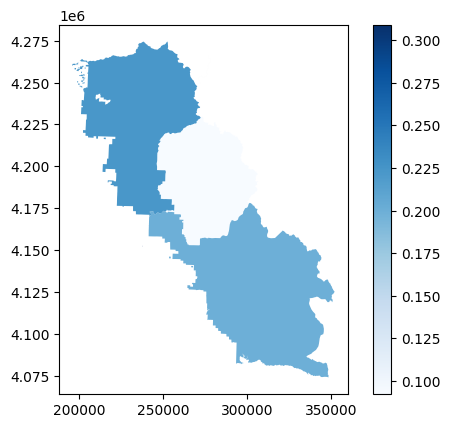

In [ ]:
# Compute mean CCVI per polygon
ccvi_stats = ccvi_joined_gdf.groupby('index_right')['CCVI'].mean().reset_index()

# Merge back to polygons
county_polys = projected_gdf.merge(ccvi_stats, left_index=True, right_on='index_right', how='left')

# Plot polygons colored by mean CCVI
county_polys.plot(column='CCVI', cmap='Blues', legend=True)


<Axes: >

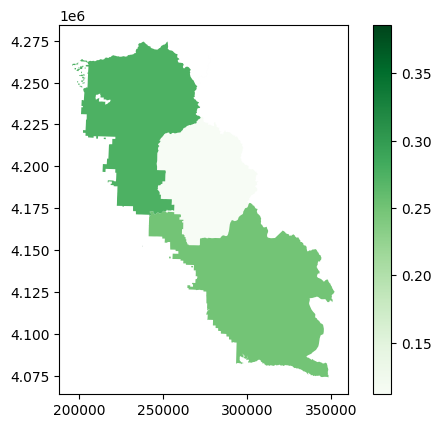

In [ ]:
# Compute mean CCVI per polygon
cli_stats = ccvi_joined_gdf.groupby('index_right')['CLI_risk'].mean().reset_index()

# Merge back to polygons
county_polys = projected_gdf.merge(cli_stats, left_index=True, right_on='index_right', how='left')

# Plot polygons colored by mean CLI stats
county_polys.plot(column='CLI_risk', cmap='Greens', legend=True)



<Axes: >

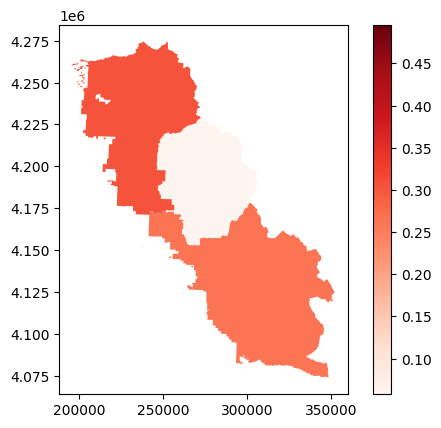

In [ ]:

# Compute mean CCVI per polygon
longterm_cli = ccvi_joined_gdf.groupby('index_right')['CLI_longterm'].mean().reset_index()

# Merge back to polygons
county_polys = projected_gdf.merge(longterm_cli, left_index=True, right_on='index_right', how='left')

# Plot polygons colored by mean CLI stats
county_polys.plot(column='CLI_longterm', cmap='Reds', legend=True)


In [ ]:
# Mapping mean CCVI with a base map to show the data in the specific county

# make sure the crs is correct
county_polys = county_polys.to_crs(epsg=4326)

# Reset index to preserve it as a column
# Drop old index columns if they exist
county_polys = county_polys.drop(columns=[col for col in ['index', 'level_0'] if col in county_polys.columns])

# Reset index safely
county_polys = county_polys.reset_index()

# Create the map
m = folium.Map(
    location=[county_polys.geometry.centroid.y.mean(),
              county_polys.geometry.centroid.x.mean()],
    zoom_start=7
)

# Add choropleth
folium.Choropleth(
    geo_data=county_polys.to_json(),
    data=county_polys,
    columns=['index', 'CCVI'],  # use reset index
    key_on='feature.properties.index',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Mean CCVI'
).add_to(m)

m


/tmp/ipython-input-3339286535.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[county_polys.geometry.centroid.y.mean(),
/tmp/ipython-input-3339286535.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_polys.geometry.centroid.x.mean()],


In [ ]:
# save this map as an html export
outhtml = f'{countyname}_{item.title}_CCVI_MEAN.html'
m.save(outhtml)
print(f'Saved {outhtml}')

Saved Mariposa County_USA Parks_CCVI_MEAN.html


# Final Exports
Exporting the selected county information as a shapefile and then as a zipfile

In [ ]:
# formatting the county name to have no spaces
no_spaces = countyname.replace(" ", "_")
print(no_spaces)


Mariposa_County


In [ ]:
shpfile_name = f'{no_spaces}_CCVI_Stats.shp'
county_polys.to_file(shpfile_name)

/tmp/ipython-input-1763159069.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  county_polys.to_file(shpfile_name)
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'OBJECTID_input' to 'OBJECTID_i'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Shape__Area_input' to 'Shape__Are'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Shape__Length_input' to 'Shape__Len'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_county' to 'index_coun'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'OBJECTID_county' to 'OBJECTID_c'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogr

In [ ]:
fname = shpfile_name.split('.')[0]
shp_to_zip = glob.glob(f'{fname}*')
shp_to_zip

['Mariposa_County_CCVI_Stats.prj',
 'Mariposa_County_CCVI_Stats.shx',
 'Mariposa_County_CCVI_Stats.shp',
 'Mariposa_County_CCVI_Stats.cpg',
 'Mariposa_County_CCVI_Stats.dbf']

In [ ]:
zipfile_name = f'Zipped_{fname}.zip'
# zip up the files
# Create a ZipFile Object
with ZipFile(zipfile_name, 'w') as zipObj:
   # Add multiple files to the zip
   for file in f_to_zip:
     zipObj.write(file)
print(f'Saved {zipfile_name}')

Saved Zipped_Mariposa_County_CCVI_Stats.zip
